In [20]:
import glob
import random
import os
import numpy as np

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms


class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train"):
        self.transform = transforms.Compose(transforms_)

        self.files = sorted(glob.glob(os.path.join(root, mode) + "/*.*"))
        if mode == "train":
            self.files.extend(sorted(glob.glob(os.path.join(root, "test") + "/*.*")))

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_A = img.crop((0, 0, w / 2, h))
        img_B = img.crop((w / 2, 0, w, h))

        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.files)


In [21]:
import torch.nn as nn
import torch.nn.functional as F
import torch


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


##############################
#           U-NET
##############################


class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x


class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)


In [22]:
epoch=0
n_epochs=200
dataset_name="real_face"
batch_size=1
lr=0.0002
b1=0.5
b2=0.999
decay_epoch=100
n_cpu=8
img_height=256
img_width=256
channels=3
sample_interval=100
checkpoint_interval=-1

In [23]:
import argparse
import os
import numpy as np
import math
import itertools
import time
import datetime
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable


import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images_cartoon/%s" % dataset_name, exist_ok=True)
os.makedirs("saved_models_cartoon/%s" % dataset_name, exist_ok=True)

cuda = True if torch.cuda.is_available() else False

# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, img_height // 2 ** 4, img_width // 2 ** 4)

# Initialize generator and discriminator
generator = GeneratorUNet()
discriminator = Discriminator()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

if epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("saved_models_cartoon/%s/generator_%d.pth" % (dataset_name, epoch)))
    discriminator.load_state_dict(torch.load("saved_models_cartoon/%s/discriminator_%d.pth" % (dataset_name, epoch)))
else:
    # Initialize weights
    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Configure dataloaders
transforms_ = [
    transforms.Resize((img_height, img_width), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.63, 0.55, 0.52), (0.22, 0.22, 0.22)),
]

dataloader = DataLoader(
    ImageDataset("../data/%s" % dataset_name, transforms_=transforms_,mode="train"),
    batch_size=batch_size,
    shuffle=True,
)

val_dataloader = DataLoader(
    ImageDataset("../data/%s" % dataset_name, transforms_=transforms_, mode="val"),
    batch_size=5,
    shuffle=True,
)

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


def sample_images(batches_done):
    """Saves a generated sample from the validation set"""
    imgs = next(iter(val_dataloader))
    real_A = Variable(imgs["B"].type(Tensor))
    real_B = Variable(imgs["A"].type(Tensor))
    fake_B = generator(real_A)
    img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2)
    save_image(img_sample, "images_cartoon/%s/%s.png" % (dataset_name, batches_done), nrow=5, normalize=True)


# ----------
#  Training
# ----------

prev_time = time.time()

for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(dataloader):

        # Model inputs
        real_A = Variable(batch["B"].type(Tensor))
        real_B = Variable(batch["A"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        fake_B = generator(real_A)
        pred_fake = discriminator(fake_B, real_A)
        loss_GAN = criterion_GAN(pred_fake, valid)
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_B, real_B)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(real_B, real_A)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach(), real_A)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f] ETA: %s"
            % (
                epoch,
                n_epochs,
                i,
                len(dataloader),
                loss_D.item(),
                loss_G.item(),
                loss_pixel.item(),
                loss_GAN.item(),
                time_left,
            )
        )

        # If at sample interval save image
        if batches_done % 100 == 0:
            sample_images(batches_done)


[Epoch 199/200] [Batch 42/43] [D loss: 0.003768] [G loss: 51.861141, pixel: 0.508194, adv: 1.041752] ETA: 0:00:00.3061968

In [5]:
%matplotlib inline
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
img_ = cv2.imread("img/2.png")
# img_ = cv2.imread("test.png")
# img_ = cv2.imread("val.png")
img = img_[:,:,::-1]


(3, 256, 256)
torch.Size([1, 3, 256, 256])


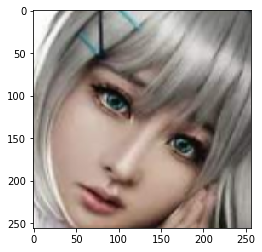

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
img = np.asarray(img)

plt.imshow(img)
img = np.transpose(img,(2,1,0))
img = img.astype(np.float32)/255.
x = 0
y = 0
img1 = img
print(img.shape)
img = torch.from_numpy(img)
a = img.unsqueeze(0)

print(a.shape)

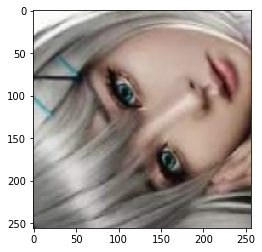

In [7]:
import torchvision
img = generator(img)
plt.imshow(np.transpose(torchvision.utils.make_grid(img.detach(), padding=2, normalize=True), (1,2,0)))